<a href="https://colab.research.google.com/github/BraulioHermanson/Machine-Learning-Project/blob/main/credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection
This project was inspired by the Kaggle competition [*Credit Card Fraud*](https://www.kaggle.com/mlg-ulb/creditcardfraud) where we have the dataset of the European cardholders. We will analyze the Fraud actions on credit cards that the dataset has through Data Science tools.

## Context
Through the dataset descriptions on the page of Kaggle, we know that the present transactions occurred in two days, and we have 492 frauds out of 284,807 transactions. The dataset is unbalanced. The positive class (frauds) accounts for 0.172% of all trades.
The dataset only contains numerical input variables resulting from a PCA transformation. Due to confidentiality issues, they cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA. The only features that have not been transformed with PCA are 'Time' and 'Amount.' Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount; this feature I will use, for example-dependant cost-sensitive learning. Feature 'Class' is the response variable, and it takes value 1 in case of fraud and 0 otherwise.

For more information and update checking out the site on Kaggle [*Credit Card Fraud*](https://www.kaggle.com/mlg-ulb/creditcardfraud)




In [ ]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# install scikit-plot
!pip install -q scikit-plot

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from imblearn.under_sampling import RandomUnderSampler

In [ ]:
file_path = '/content/creditcard.csv'
df = pd.read_csv(file_path)

# EDA - Exploratory Data Analysis

As always, when I'm doing *EDA*, I'm going to use the method `head()` to check the dataset, `print` the number of `Samples` and `Features`, and use the `describe()` to visualize the statistical summary.
If I found some NaN value on the features **Amount** and **Class**, I will remove those NaN from the dataset.


In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
print("Samples:\t{}".format(df.shape[0]))
print("Features:\t{}\n".format(df.shape[1]))

Samples:	284807
Features:	31



In [ ]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,-1.040458,-0.031513,-0.188093,-0.084316,0.041333,-0.302620,-0.660377,0.167430,-0.256117,0.382948,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [ ]:
df.isnull().sum().max()

0

In [ ]:
df.drop(axis =0,index=29798,inplace=True)

In [ ]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,-1.040458,-0.031513,-0.188093,-0.084316,0.041333,-0.302620,-0.660377,0.167430,-0.256117,0.382948,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


# Does the dataset have some correlation?

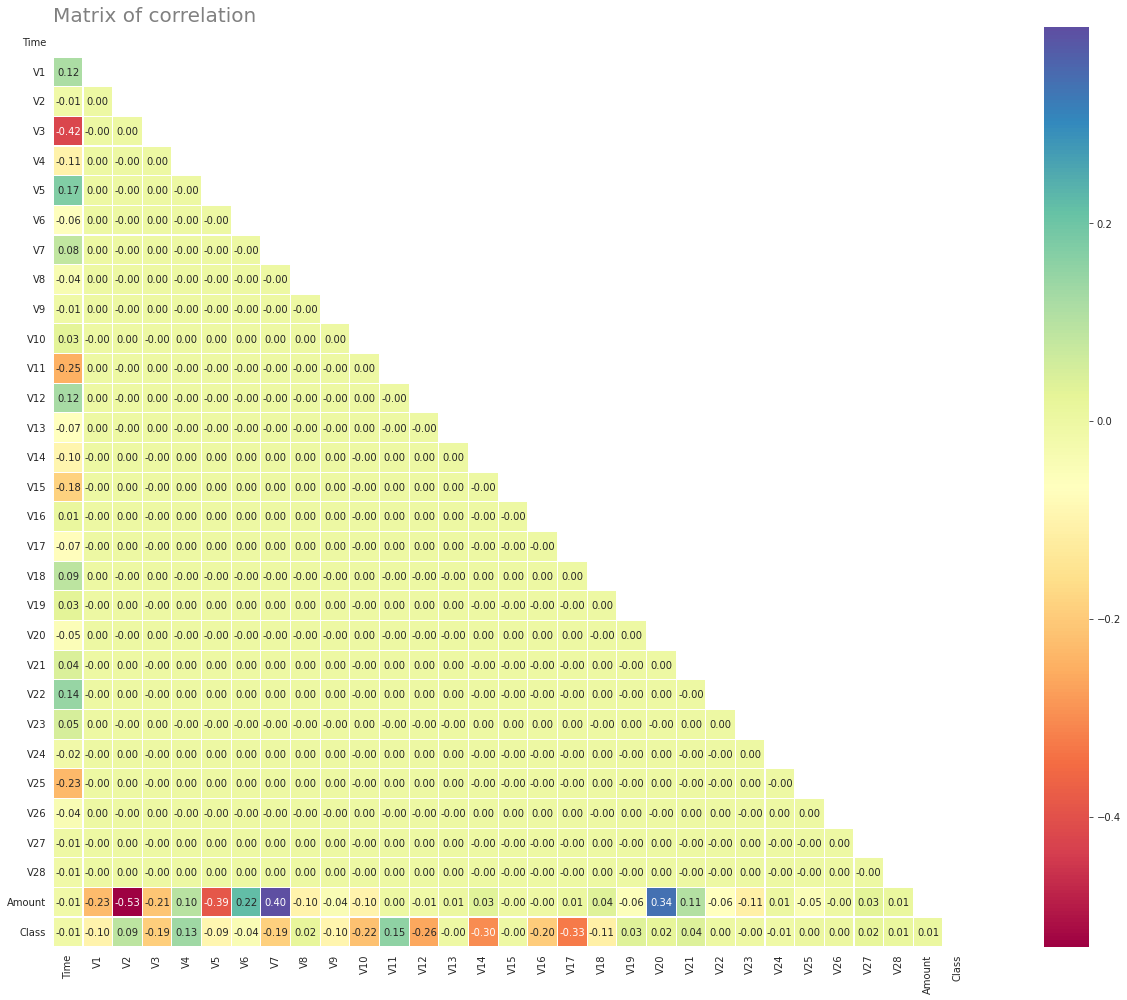

In [ ]:

corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(nrows=1, ncols =1, figsize=(20,14))
    ax = sns.heatmap(corr,mask=mask,xticklabels = corr.columns, yticklabels = corr.columns,linewidths=.1, cmap='Spectral', fmt='.2f',square=True, linecolor='white',ax = ax,annot=True );



ax.set_title("Matrix of correlation",color= 'Grey', fontsize=20,loc='left')
plt.tight_layout()



Then we can see the dataset it's messing. Since I am going to start from scratch, I will analyze the features `Class`, `Amount` and `Time` first, and then, I will plot histograms for the other features because this feature has suffered changes from the PCA method

# Understand the values of the Features Amount and Class

By the `describe()` method, you can notice two exciting details:

The first is that the average of the Class feature values is 0.0032 rounding. That is, we have many more values indicating regular operations [0] than fraudulent[1];
The average of the Amount column is not very high, so we have that the average of the transacted values is around US$ 79.62, median equal to 20.00, and standard deviation of 222.11. So when you look at the maximum amount transacted, you realize that it may have been a fraud situation or just an outlier because most financial transactions are much smaller.

In [ ]:
df[['Amount','Class']].describe().round(4)

,Amount,Class
count,284806.0000,284806.0000
mean,88.3499,0.0017
std,250.1205,0.0415
min,0.0000,0.0000
25%,5.6000,0.0000
50%,22.0000,0.0000
75%,77.1675,0.0000
max,25691.1600,1.0000


# Understand the features **Class**,**Time** and **Amount**


## **Class**
The bar chart below shows how unbalanced the class columns are and this, in practice, interferes with the understanding and performance of the machine learning model.  Balancing the data before feeding the final classification model is necessary to avoid this.

The amount of regular cases on the dataset are 99.83%. 	
However for the fraud are only 0.173%.



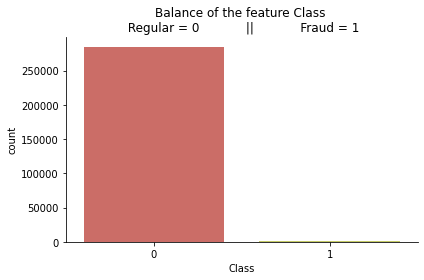

In [ ]:
# Distortion of the feature Class 
print("The amount of regular cases on the dataset are {:.4}%. \t".format(df['Class'].value_counts()[0]/len(df)*100))
print("However for the fraud are only {:.3}%.\n".format(df['Class'].value_counts()[1]/len(df)*100))

# Calling the method countplot() to see the distribution of data on the feature Class
color = sns.color_palette("hls")
 #palette = color
ax = sns.countplot(x="Class", data=df, palette = color)

plt.title('Balance of the feature Class \n Regular = 0            ||            Fraud = 1')
plt.tight_layout()
sns.despine()

## **Time** and **Amount**
And to identify if the features Time and Amount have a balanced distribution on the dataset, I will use the histograms to check this out.

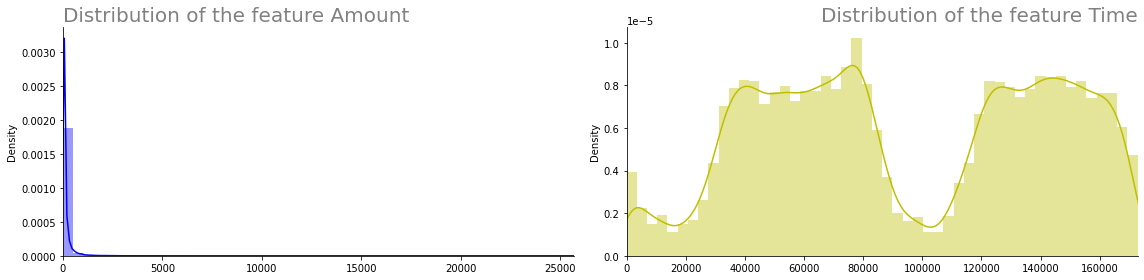

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='b')
ax[0].set_title('Distribution of the feature Amount',color= 'Grey',fontsize=20,loc='left')
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='y')
ax[1].set_title('Distribution of the feature Time',color= 'Grey', fontsize=20,loc='right')
ax[1].set_xlim([min(time_val), max(time_val)])

plt.tight_layout()
sns.despine()

Now, let's check out the relationship with the features Amount with the feature Class and understand if I will have more Fraud or more Normal.
Since I have many data, I will use the feature Amount until 2000 to analyze because the histogram above me shows us a low density of values higher than 2000.

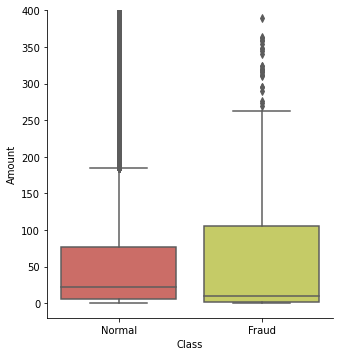

In [ ]:
sns.catplot(x ="Class" , y ="Amount", data = df, kind = "box", palette = color)
plt.ylim(-20,400)
plt.xticks([0,1],["Normal", "Fraud"])
 
plt.show()

In [ ]:
# Fraud is 1
df[(df.Class==1) & (df.Amount < 2000)]['Amount'].describe()

count     491.000000
mean      118.130550
std       240.439028
min         0.000000
25%         1.000000
50%         9.210000
75%       105.350000
max      1809.680000
Name: Amount, dtype: float64

In [ ]:
# Normal is 0
df[(df.Class==0) & (df.Amount < 2000)]['Amount'].describe()

count    283624.000000
mean         80.545189
std         172.632179
min           0.000000
25%           5.550000
50%          21.970000
75%          76.122500
max        1999.890000
Name: Amount, dtype: float64

## Histograms for the rest of features

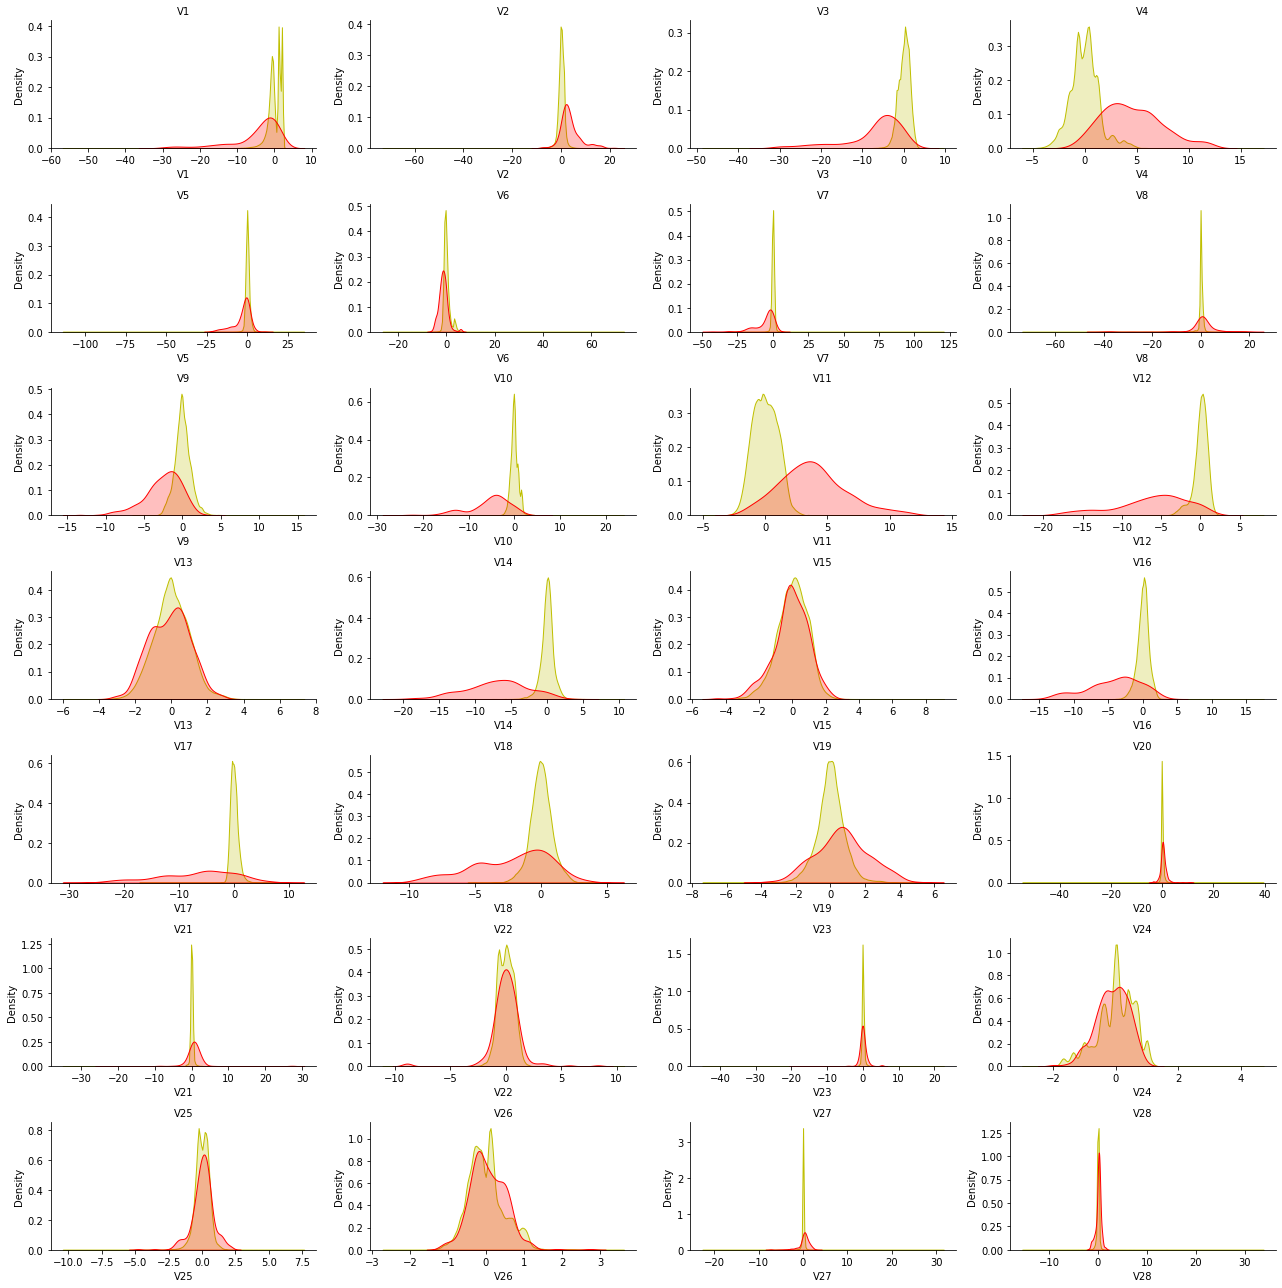

In [ ]:

columns = df.drop(['Class', 'Amount', 'Time'], axis=1).columns
num_plots = len(columns)
df_regular = df[df.Class == 0]
df_fraude = df[df.Class == 1]

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)

conta = 0
for col in columns:
    conta += 1
    plt.subplot(7, 4, conta)
    sns.kdeplot(df_regular[col], label="Class 0", shade=True, color = "y")
    sns.kdeplot(df_fraude[col], label="Class 1", shade=True, color = "r")
    plt.title(col, fontsize=10)
  
sns.despine()
plt.tight_layout()

Then we can see that the dataset is unbalanced, and I will need to do some work to achieve the best balance of the dataset, and then I will be able to start applying the ML model.

# Standardize the Time and Amount variables



In this step, the feature `Time` and `Amount`  will be standardized through the **RboustScaler** class because it is less sensitive to outliers. And they will be arranged right at the start of the DataFrame.

In [ ]:
df_clean = df.copy()

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df_clean['norm_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df_clean['norm_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))


df_clean.drop(['Amount','Time'], axis = 1, inplace = True)

In [ ]:
# Declare normalized columns
norm_amount = df_clean['norm_amount']
norm_time = df_clean['norm_time']

# Redirecting and applying the normalize for the features Time and Amount 
df_clean.drop(['norm_amount','norm_time'], axis = 1, inplace = True)
df_clean.insert(0, 'norm_amount', norm_amount)
df_clean.insert(1,"norm_time", norm_time)

df_clean.head()

,norm_amount,norm_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783212,-0.994995,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269815,-0.994995,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983547,-0.994983,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418242,-0.994983,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670556,-0.994972,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


# Splitting the dataset into **train** and **test**

In [ ]:
X = df_clean.drop("Class", axis = 1)
y = df_clean["Class"]


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, shuffle = True)

1    369
0    369
Name: Class, dtype: int64


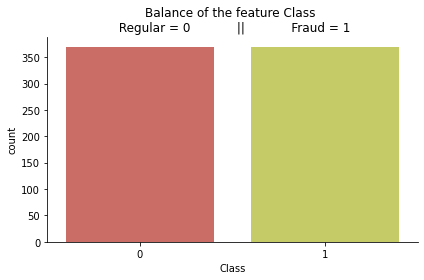

In [ ]:
# Apply RandomUnderSample
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train,y_train)

# see the balance
print(pd.Series(y_rus).value_counts())


color = sns.color_palette("hls")
sns.countplot(y_rus, palette = color)
plt.title('Balance of the feature Class \n Regular = 0            ||            Fraud = 1')
plt.tight_layout()
sns.despine()

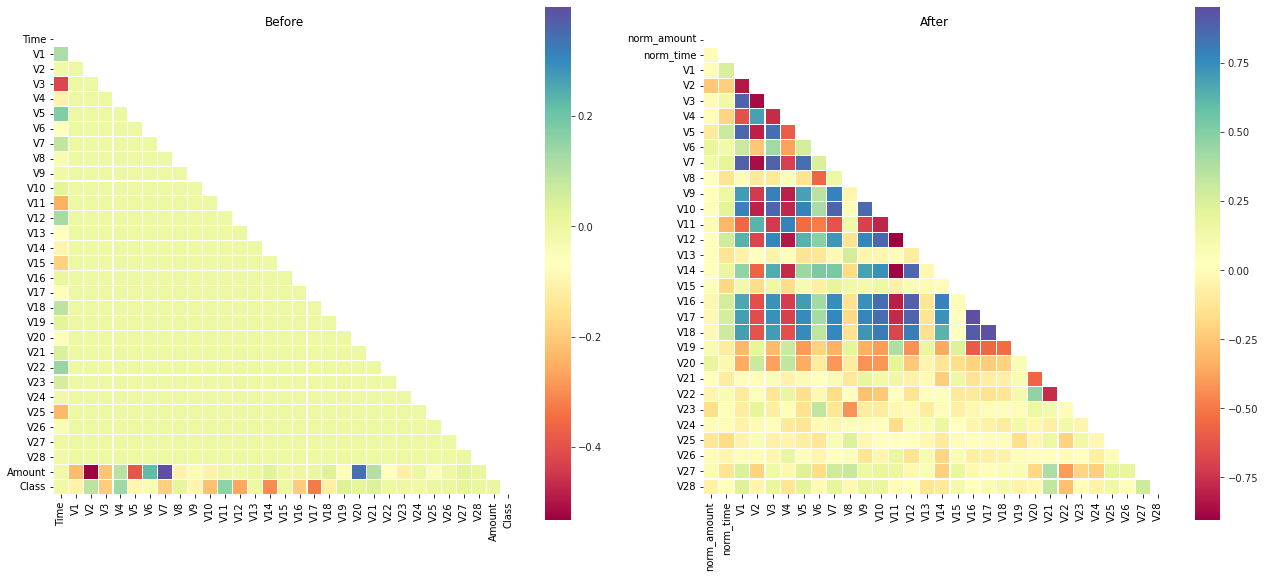

In [ ]:

corre = X_train.corr()
corr_rus = pd.DataFrame(X_rus).corr()

f, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize =(18,8))

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr,mask=mask,xticklabels = corr.columns, yticklabels = corr.columns,linewidths=.1, cmap='Spectral', fmt='.2f',square=True, linecolor='white',ax = ax1);
ax1.set_title("Before")

mask1 = np.zeros_like(corr_rus)
mask1[np.triu_indices_from(mask1)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr_rus,mask=mask1,xticklabels = corr_rus.columns, yticklabels = corr_rus.columns,linewidths=.1, cmap='Spectral', fmt='.2f',square=True, linecolor='white',ax = ax2 );
ax2.set_title("After")

plt.tight_layout()

# Machine Learning Model

Now with the data balanced, we can apply the ML model, and the model that I'm going to use is the classification model.
In this case, I`m going to use the LogisticRegression.

In [ ]:
# Logistic Regression

# 1. import and choosing the model
from sklearn.linear_model import LogisticRegression

np.random.seed(2)
# 2. select the model
model = LogisticRegression()

# 3. fit the model
model.fit(X_rus, y_rus)

# 4. Predicticion above the new cases
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

## The performance of the model

**Recall**: give us the proportion of the positives found correctly.

**Accuracy**: Show us the % of the rightness of the regression model.

Confusion Matrix: Each class informs what values are True and predicted values for the model.
The chart above in the x-axis shows us the True, and the y-axis shows the prediction so that the graph can be read in this way:

0X0 : % of the regular predictions and the model shows us as regular.

0X1 : % of the cases that weren't fraud, but the model shows us as fraud.

1X0 : % of the cases were fraud, but the model shows us regular.

1X1 : % of the fraud cases, and the model shows as fraud. 

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9646    0.9819     71079
           1     0.0434    0.9268    0.0829       123

    accuracy                         0.9646     71202
   macro avg     0.5216    0.9457    0.5324     71202
weighted avg     0.9982    0.9646    0.9804     71202

Acurácia: 0.9646

AUC: 0.9457



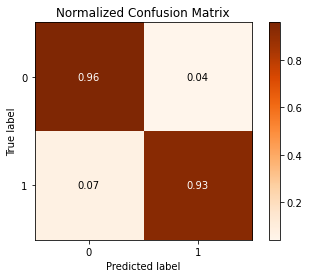

In [ ]:
# confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True,cmap='Oranges')

# print report
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

# print the accuracy of the model
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

# print the area under the curve
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

## ROC curve

**The area on the ROC curve (AUC)**:

This summarizes how skillful the machine learning algorithm is predicting. The AUC value tells us whether the prediction is 100% wrong for cases where AUC = 0 or 100% correct for predictions where AUC = 1. That is, the closer to 1, the better the model.

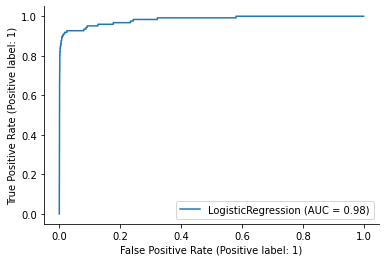

In [ ]:
from sklearn import metrics
metrics.plot_roc_curve(model,X_test,y_test)
sns.despine()
plt.show()

## Analysis of the result

Then we can conclude that wthe metrics are good,because the balance give us a good model that was able to identify  90 % of the metrics that are important to indentify the frauds as:

**Recal**: 0.9646

**Accuracy**: 0.9646

**Confusion Matrix**: 0.93

**ROC (AUC)**: 0.9457

# #Plus

Using the Descion Tree model

# Decision Tree

In [ ]:
# 1. import and choosing the model
from sklearn.tree import DecisionTreeClassifier 

np.random.seed(2)
# 2. Instantiate and choose models
modelo = DecisionTreeClassifier(max_depth=8, criterion = "entropy")

# 3. fit the model
modelo.fit(X_rus, y_rus)

# 4. Predicticion above the new cases
y_predi = modelo.predict(X_test)
y_proba = modelo.predict_proba(X_test)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.91      0.95     71079
           1       0.02      0.90      0.03       123

    accuracy                           0.91     71202
   macro avg       0.51      0.91      0.49     71202
weighted avg       1.00      0.91      0.95     71202

Acurácia: 0.9086

AUC: 0.9055



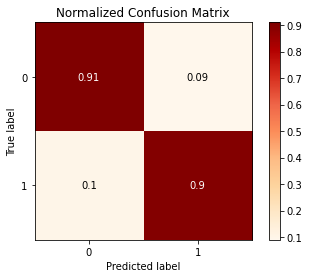

In [ ]:
# classification_report
print("Classification Report: \n",classification_report(y_test,y_predi))
 
# print model accuracy
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_predi)))
 
# print the area under the curve
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_predi)))
 
# Confusion Matrix
skplt.metrics.plot_confusion_matrix(y_test, y_predi, normalize=True, cmap = 'OrRd')

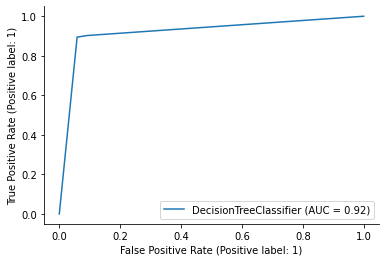

In [ ]:
# ROC curv for the decision tree
from sklearn import metrics
metrics.plot_roc_curve(modelo,X_test,y_test)
sns.despine()
plt.show()

# Showing the Decision Tree

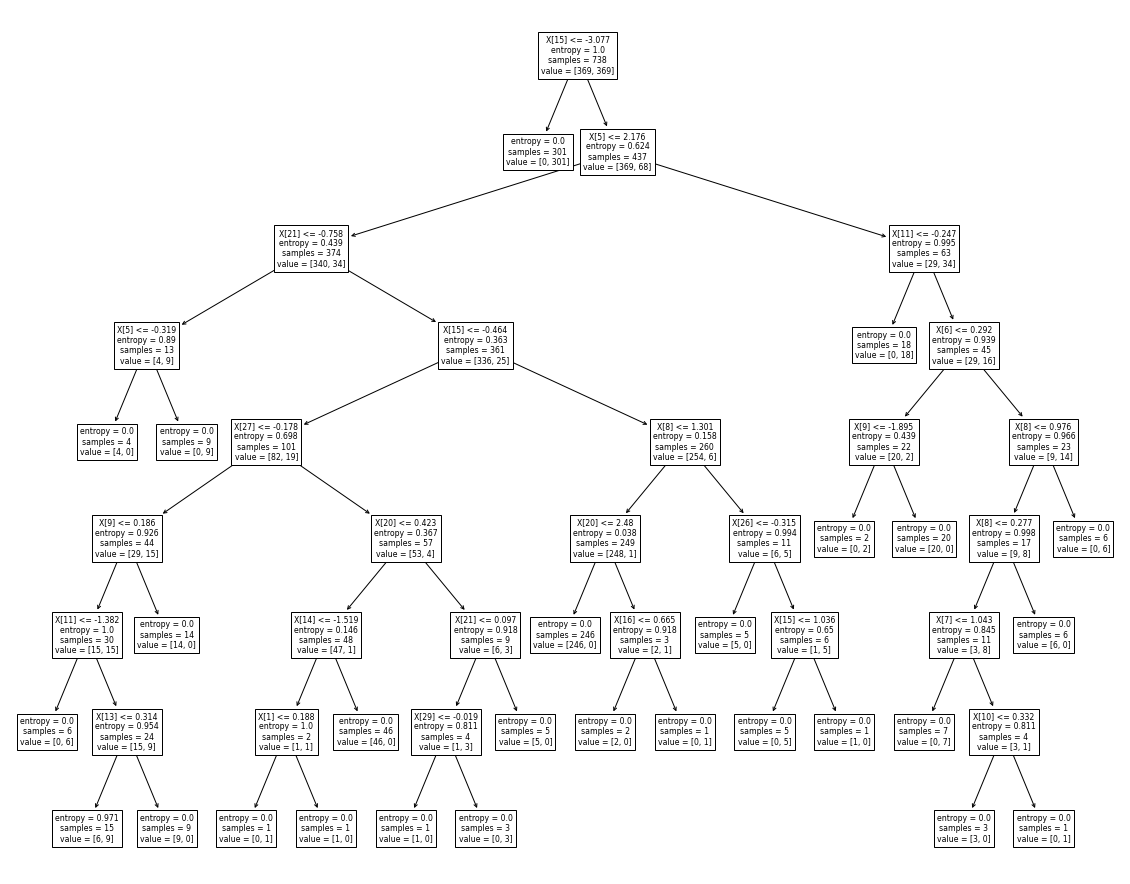

In [ ]:
from sklearn import tree
#%pylab inline

fig, ax = plt.subplots(figsize=(20,16))
tree.plot_tree(modelo.fit(X_rus, y_rus))
plt.show()